<div style="color:white; background:black; text-align: center; font-size: 16px; padding: 1px;">
    <h2>Tweets Sentiment Analysis with <span style="color:blue;">Transformers</span></h2>
    <h3><span style="color:blue;">BERT</span> and BERT+Recurrent Networks</h3>
    <h4><span style="color:blue;">PyTorch</span></h4>
    <p style="position:absolute; bottom:8px; right:20px;">7 May</p>
</div>


# **Imports** 

In [62]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss
from collections import defaultdict
from tqdm import tqdm
import time

from sklearn.metrics import confusion_matrix
# !pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 


# !pip install fvcore
from fvcore.nn import FlopCountAnalysis
from sklearn.metrics.pairwise import cosine_similarity



import torch.optim as optim
from transformers import get_linear_schedule_with_warmup

from torch.nn import CrossEntropyLoss
import time

import re
from collections import Counter
from collections import defaultdict
from tqdm import tqdm
import torch.nn.functional as F
import torch
import re

# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.utils import class_weight

from collections import Counter
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch.nn as nn

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch.optim as optim
import torchtext
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time

# **Data Loading**

In [63]:
file_path = "/kaggle/input/tweetsdata/tweet_sentiment_train.csv"
df = pd.read_csv(file_path)
df

,Unnamed: 0,textID,text,selected_text,sentiment
0,7025,da4d705179,in 8th grade yearbook: for narnia movie releas...,in 8th grade yearbook: for narnia movie releas...,neutral
1,15039,989f65a4aa,ah remember the days when you`d sleep in until...,loser,negative
2,1804,f3244dc22d,my momma is comin 2night ! 2morrow tennis day...,yuppie,positive
3,25874,21c7ca7c01,my picture wont come up it keeps saying thats...,my picture wont come up it keeps saying thats...,neutral
4,27217,16e3bfcd31,We don`t feel too comfortable using it. It`s...,". It`s not awful, but pretty icky",negative
...,...,...,...,...,...
21979,23242,a87eed2a66,I want to be at,I want to be at,neutral
21980,7595,9986499587,Thinks she`s getting sick.....,Thinks she`s getting sick.....,negative
21981,763,44eba69b30,oh wow...hope he`s ok u take him 2 the vet?,oh wow...hope he`s ok u take him 2 the vet?,neutral
21982,11516,b2c78b1572,"goodnight twitter, ill see you after 10 + hour...","goodnight twitter, ill see you after 10 + hour...",neutral


# **Data Exploration**

la dimension de notre data  : (21984, 5)


Any null values: 2


Columns: Index(['Unnamed: 0', 'textID', 'text', 'selected_text', 'sentiment'], dtype='object')


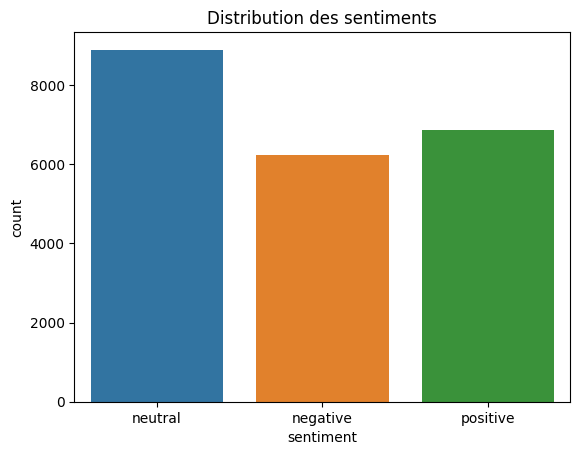

0    in 8th grade yearbook: for narnia movie releas...
1    ah remember the days when you`d sleep in until...
2    my momma is comin 2night !  2morrow tennis day...
Name: text, dtype: object

In [64]:
print('la dimension de notre data  :' , df.shape)
print("\n")
print("Any null values:", df.isnull().sum().sum())
print("\n")
print("Columns:", df.columns)  
sns.countplot(x='sentiment', data=df)
plt.title('Distribution des sentiments')
plt.show()
print("\n")
df['text'].iloc[0:3]

# **Data Processing**

In [65]:
df = df.dropna() #supprimer les valerius nulls 

In [66]:
X = []
sentences = df['text']
for sen in sentences:
 X.append(sen)

In [67]:
pattern = re.compile(r"[^a-zA-Z\s']")

unwanted_chars = Counter()

for text in X:
    unwanted = pattern.findall(text)
    unwanted_chars.update(unwanted)

print("les caracteres indesirables  :", dict(unwanted_chars))

les caracteres indesirables  : {'8': 431, ':': 1935, ',': 6782, '!': 12311, '`': 9329, '?': 3487, '2': 1416, '.': 28585, ';': 283, '-': 2196, '&': 634, '7': 416, '0': 1367, '3': 1079, '6': 556, '/': 3633, '4': 869, '@': 251, '1': 1314, '_': 1237, 'ï': 178, '¿': 178, '½': 178, ')': 711, '5': 694, '#': 494, '%': 41, '~': 143, '(': 596, '*': 4031, '<': 266, '9': 375, '=': 173, '+': 107, '>': 96, '[': 36, ']': 58, '$': 117, '|': 26, '\\': 15, '^': 30, '{': 4, '}': 5, 'Â': 5, '´': 1}


In [68]:
TAG_RE = re.compile(r'<[^>]+>')
URL_RE = re.compile(r'http\S+|www.\S+')
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#\w+')
PATTERN = re.compile(r"[^a-zA-Z\s]")  

def remove_tags(text):
    return TAG_RE.sub('', text)

def remove_urls(text):
    return URL_RE.sub('', text)

def remove_mentions(text):
    return MENTION_RE.sub('', text)

def remove_hashtags(text):
    return HASHTAG_RE.sub('', text)

def remove_unwanted_chars(text):
    return PATTERN.sub('', text)

def preprocess_text(sen):
    sentence = remove_tags(sen)
    sentence = remove_urls(sentence)
    sentence = remove_mentions(sentence)
    sentence = remove_hashtags(sentence)
    sentence = remove_unwanted_chars(sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sentence.lower()
    sentence = sentence.strip()
    return sentence

example_text = "I4'm ha2ykel bargougui i ., check this out! https://example.com @user #awesome <div>HTML</div>."
processed_text = preprocess_text(example_text)
print(processed_text)

im haykel bargougui check this out html


In [69]:
X = [preprocess_text(tweet) for tweet in X]

In [71]:
X[:30]

['in th grade yearbook for narnia movie release blurb pic of aslan and my skandar',
 'ah remember the days when youd sleep in until noon well guess who did that today god feel like loser',
 'my momma is comin night morrow tennis day with pnar yuppie',
 'my picture wont come up it keeps saying thats nice picture but where is it',
 'we dont feel too comfortable using it its not awful but pretty icky scurrying to find deal',
 'fjgkfldsdh why am not at hometown days with my friends',
 'oh man would but im fresh out',
 'good luck tonight have fun',
 'changing guitar strings getting ready to perform the climb at my cousins birthdayy',
 'everyone vote for for the mtv movie awards coz my comp is mashed up and wont let me vote will somehow',
 'good luck have funn',
 'same its just not happening and im going out too uhoh',
 'it is so annoying when she starts typing on her computer in the middle of the night',
 'ugh rude',
 'any chance of seeing yo at race in germany unfortunately hardly any tv n

In [72]:
pattern = re.compile(r"[^a-zA-Z\s]")

unwanted_chars = Counter()

for text in X:
    unwanted = pattern.findall(text)
    unwanted_chars.update(unwanted)

print("Unwanted characters :", dict(unwanted_chars))

Unwanted characters : {}


#  **Sentiment encoding**

In [25]:
print(df['sentiment'].unique())
y = df['sentiment']
y = np.array(list(map(lambda x: 1 if x == "positive" else 0 if x == "negative" else 2, y)))

['neutral' 'negative' 'positive']


# **Text OR Selected_text?**

In [59]:
file_path = "/kaggle/input/tweetsdata/tweet_sentiment_train.csv"
df = pd.read_csv(file_path)

df.dropna(subset=['text', 'selected_text'], inplace=True)


df['text_cleaned'] = df['text'].apply(preprocess_text)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    encodings = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    encodings = {key: val.to(device) for key, val in encodings.items()}
    with torch.no_grad():
        outputs = model(**encodings)
        embeddings = outputs.last_hidden_state.mean(1)  # Mean pooling
    return embeddings.cpu()

similarities = []
for _, row in df.iterrows():
    texts = [row['text_cleaned'], row['selected_text']]
    embeddings = get_bert_embeddings(texts)
    similarity = cosine_similarity(embeddings[0:1], embeddings[1:])
    similarities.append(similarity[0][0])

df['similarity'] = similarities

print(df.head())

   Unnamed: 0      textID                                               text  \
0        7025  da4d705179  in 8th grade yearbook: for narnia movie releas...   
1       15039  989f65a4aa  ah remember the days when you`d sleep in until...   
2        1804  f3244dc22d  my momma is comin 2night !  2morrow tennis day...   
3       25874  21c7ca7c01  my picture wont come up  it keeps saying thats...   
4       27217  16e3bfcd31    We don`t feel too comfortable using it. It`s...   

                                       selected_text sentiment  \
0  in 8th grade yearbook: for narnia movie releas...   neutral   
1                                              loser  negative   
2                                             yuppie  positive   
3  my picture wont come up  it keeps saying thats...   neutral   
4                  . It`s not awful, but pretty icky  negative   

                                        text_cleaned  similarity  
0  in th grade yearbook for narnia movie release ...   

In [60]:
average_similarity = df['similarity'].mean()
print("Average Similarity:", average_similarity)

Average Similarity: 0.70712054


# **Configuration** 

In [29]:
config = {
    "MODEL_NAME": "bert-base-uncased",
    "MAX_LEN": 30,  
    "n_classes": 3,
    "batch_size": 32,
    "OUTPUT_DIM" : 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "N_CLASSES": 3,
    "N_LAYERS": 2,
    "HIDDEN_DIM": 256,
    "BIDIRECTIONAL": True,
    "DROPOUT": 0.2
}

# **BertTokenizer**

In [30]:
tokenizer = BertTokenizer.from_pretrained(config["MODEL_NAME"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
vocab_size = tokenizer.vocab_size
print("Vocabulary size:", vocab_size)
vocabulary = tokenizer.vocab

Vocabulary size: 30522


100%|██████████| 21983/21983 [00:11<00:00, 1890.79it/s]


<Axes: ylabel='Density'>

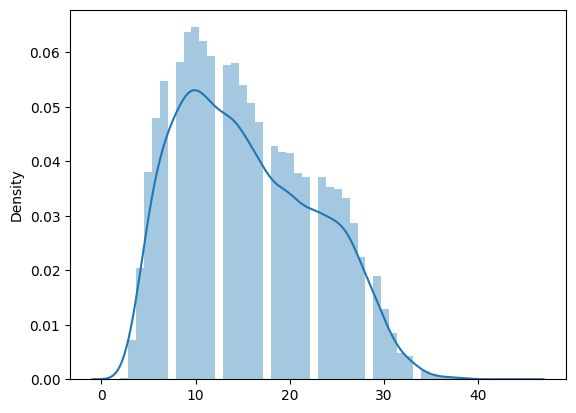

In [20]:
token_lens = []
for txt in tqdm(X):
  tokens = tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.distplot(token_lens)

In [42]:
MAX_LEN = 30

In [26]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42, shuffle=True)

In [23]:
# X_train = X_train[:100]
# y_train = y_train[:100]
# X_val = X_val[:100]
# y_val = y_val[:100]

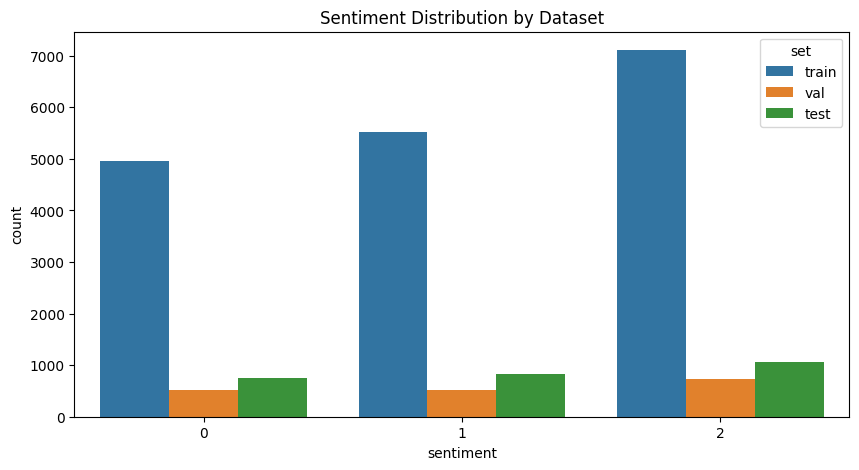

In [24]:
train_df = pd.DataFrame({'sentiment': y_train, 'set': 'train'})
val_df = pd.DataFrame({'sentiment': y_val, 'set': 'val'})
test_df = pd.DataFrame({'sentiment': y_test, 'set': 'test'})

combined_df = pd.concat([train_df, val_df, test_df])

plt.figure(figsize=(10, 5))
sns.countplot(x='sentiment', hue='set', data=combined_df)
plt.title('Sentiment Distribution by Dataset')
plt.show()

In [25]:
print(len(X_train))

17586


In [26]:
print(len(X_val))

1758


In [27]:
print(len(X_test))

2639


# **DATASET**

In [19]:
class SentimentDataset(Dataset):
    def __init__(self,text,sentiment,tokenizer,max_len):
        self.text = text
        self.sentiment = sentiment
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = str(self.text[item])
        sentiment = self.sentiment[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }

# **Data Loader**

In [20]:
def create_data_loader(texts , sentiments , tokenizer, max_len, batch_size):
    data = SentimentDataset(
        text=texts,
        sentiment=sentiments,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        data,
        batch_size=batch_size,
        num_workers=4
    )

In [21]:
def initialize_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, tokenizer, max_len, batch_size):
    """
    Initializes data loaders for training, validation, and testing datasets.

    Args:
    X_train (list): Training data features.
    y_train (list): Training data labels.
    X_val (list): Validation data features.
    y_val (list): Validation data labels.
    X_test (list): Test data features.
    y_test (list): Test data labels.
    tokenizer: Tokenizer to be used for encoding the texts.
    max_len (int): Maximum length of the tokens.
    batch_size (int): Batch size for the data loaders.

    Returns:
    tuple: Returns training, validation, and test data loaders.
    """
    train_data_loader = create_data_loader(X_train, y_train, tokenizer, max_len, batch_size)
    val_data_loader = create_data_loader(X_val, y_val, tokenizer, max_len, batch_size)
    test_data_loader = create_data_loader(X_test, y_test, tokenizer, max_len, batch_size)

    return train_data_loader, val_data_loader, test_data_loader

In [31]:
train_data_loader, val_data_loader, test_data_loader = initialize_data_loaders(
    X_train,
    y_train,
    X_val, y_val,
    X_test,
    y_test,
    tokenizer,
    config['MAX_LEN'],
    config['batch_size']
)

# **Models**

<div style="color:white; background:black; text-align: center; font-size: 16px;padding: 1px;">
<h3>BERT with Fully Connected Layers</h3>
</div>


In [34]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes, freeze_bert=False):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)

        D_in, H, D_out = self.bert.config.hidden_size, 50, n_classes
        self.classifier = nn.Sequential(
#             output=input×weight+bias
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )
#         freeze=True ======requires_grad=False  
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        last_hidden_state_cls = outputs[0][:, 0, :]
        
        logits = self.classifier(last_hidden_state_cls)

        return logits

<div style="color:white; background:black; text-align: center; font-size: 16px;padding: 1px;">
<h3>BERT with LSTM</h3>
</div>


In [35]:
class BERTLSTMSentiment(nn.Module):
    def __init__(self, model_name, hidden_dim, n_layers, bidirectional, dropout, n_classes):
        super().__init__()
        
        self.bert = BertModel.from_pretrained(model_name)
        embedding_dim = self.bert.config.hidden_size
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True,
                            dropout=0 if n_layers < 2 else dropout)
        
        # Adjusting output layer dimensions based on bidirectionality
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, n_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            embedded = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
        
        # LSTM output handling
        _, (hidden, _) = self.lstm(embedded)
        
        if self.lstm.bidirectional:
            # Concatenate the final forward and backward hidden states
            hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
            # Use the final hidden state
            hidden = self.dropout(hidden[-1, :, :])
        
        output = self.out(hidden)
        
        return output

<div style="color:white; background:black; text-align: center; font-size: 16px;padding: 1px;">
<h3>BERT with GRU</h3>
</div>


In [36]:
class BERTGRUSentiment(nn.Module):
    def __init__(self, model_name, hidden_dim, output_dim, n_layers, bidirectional, dropout, n_classes):
        super().__init__()
        
        self.bert = BertModel.from_pretrained(model_name)
        
        embedding_dim = self.bert.config.hidden_size
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers=n_layers,
                          bidirectional=bidirectional,
                          batch_first=True,
                          dropout=0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, n_classes)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            embedded = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
                
        _, hidden = self.rnn(embedded)
        
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
            hidden = self.dropout(hidden[-1, :, :])
                
        output = self.out(hidden)
        
        return output

## **Models Informations : total_params + total_gflops**

In [37]:
def models_info(model, batch_size, seq_length, device=config["device"]):
    model = model.to(device)
    
    # Display the model's architecture
    print("Model Architecture:")
    print(model)
    
    if hasattr(model, 'config'):
        print("\nModel Configuration:")
        print(model.config)
    
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of trainable parameters: {total_params}')
    
    input_ids = torch.randint(0, 1000, size=(batch_size, seq_length)).to(device)
    attention_mask = torch.ones((batch_size, seq_length)).to(device)
    inputs = (input_ids, attention_mask)
    
    flops = FlopCountAnalysis(model, inputs)
    total_flops = flops.total()
    total_gflops = total_flops / 1e9  # Convert from FLOPs to GFLOPs
    print(f'Number of GFLOPs: {total_gflops}')

    return total_params, total_gflops

# **Train**

In [36]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()  
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
#         print(input_ids.shape)
        attention_mask = data['attention_mask'].to(device)
#         print(attention_mask.shape)
        targets = data['sentiment'].to(device) 
#         print(targets.shape)

        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    accuracy = correct_predictions.double() / len(data_loader.dataset)
    average_loss = np.mean(losses)

    return accuracy, average_loss

# **Eval**

In [37]:
def eval_model(model, data_loader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    losses = []
    correct_predictions = 0
    total_time = 0
    num_batches = 0

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['sentiment'].to(device)

            start_time = time.time()  # Start timing the inference
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            end_time = time.time()  # End timing the inference

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            correct_predictions += torch.sum(preds == targets)
            total_time += (end_time - start_time)
            num_batches += 1

    average_loss = np.mean(losses)
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    average_inference_time = total_time / num_batches

    return accuracy, average_loss, average_inference_time

# **Trainer**

In [38]:
def trainer(model, train_data_loader=train_data_loader, val_data_loader=val_data_loader, device=config['device'],
            results_file='bert_results.txt', model_file='bert_best_model.pt'):
    EPOCHS=40
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    loss_fn = CrossEntropyLoss().to(device)

    start_time = time.time()
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in tqdm(range(EPOCHS), desc="Epochs"):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 100)
        
        train_acc, train_loss = train_model(
            model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            scheduler
        )
        print(f'Train loss {train_loss} accuracy {train_acc}')
        
        val_acc, val_loss, _ = eval_model(
            model,
            val_data_loader,
            loss_fn,
            device
        )
        print(f'Val loss {val_loss} accuracy {val_acc}')
        
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), model_file)
            best_accuracy = val_acc

        with open(results_file, 'a') as f:
            f.write(f'Epoch {epoch + 1}/{EPOCHS}\n')
            f.write(f'Train loss: {train_loss}, accuracy {train_acc}\n')
            f.write(f'Val loss: {val_loss}, accuracy {val_acc}\n\n')

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")

    return history

# **Models' training & Results**

<div style="color:white; background:black; text-align: center; font-size: 16px;padding: 1px;">
<h3>BERT </h3>
</div>


In [39]:
model_name = config['MODEL_NAME']

In [40]:
Bertmodel = SentimentClassifier(config["n_classes"])
Bertmodel = Bertmodel.to(config["device"])

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [43]:
total_params_BERT, total_gflops_BERT = models_info(Bertmodel, config['batch_size'], MAX_LEN, config["device"])

Model Architecture:
SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), 

In [42]:
training_history = trainer(Bertmodel,
                           results_file='bert_results.txt',
                           model_file='bert_best_model.pt')

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40
----------------------------------------------------------------------------------------------------
Train loss 0.6512281503731554 accuracy 0.7273967929034459
Val loss 0.5644222367893565 accuracy 0.7787258248009101


Epochs:   2%|▎         | 1/40 [01:05<42:28, 65.33s/it]

Epoch 2/40
----------------------------------------------------------------------------------------------------
Train loss 0.4630710262331096 accuracy 0.8246900943932673
Val loss 0.5641785161061721 accuracy 0.7872582480091012


Epochs:   5%|▌         | 2/40 [02:10<41:20, 65.27s/it]

Epoch 3/40
----------------------------------------------------------------------------------------------------
Train loss 0.34211098710244353 accuracy 0.8786534743546003


Epochs:   8%|▊         | 3/40 [03:14<39:55, 64.75s/it]

Val loss 0.645986407995224 accuracy 0.7736063708759954
Epoch 4/40
----------------------------------------------------------------------------------------------------
Train loss 0.2495461880178614 accuracy 0.9184578642101672


Epochs:  10%|█         | 4/40 [04:18<38:43, 64.54s/it]

Val loss 0.7500679465857419 accuracy 0.7787258248009101
Epoch 5/40
----------------------------------------------------------------------------------------------------
Train loss 0.190773599058051 accuracy 0.9401228249744115


Epochs:  12%|█▎        | 5/40 [05:23<37:34, 64.42s/it]

Val loss 0.8864612302996896 accuracy 0.775881683731513
Epoch 6/40
----------------------------------------------------------------------------------------------------
Train loss 0.14655734562061049 accuracy 0.957352439440464


Epochs:  15%|█▌        | 6/40 [06:27<36:32, 64.48s/it]

Val loss 0.9711868529969996 accuracy 0.7679180887372014
Epoch 7/40
----------------------------------------------------------------------------------------------------
Train loss 0.11762525205077096 accuracy 0.9669054930058001


Epochs:  18%|█▊        | 7/40 [07:32<35:26, 64.44s/it]

Val loss 1.098421110348268 accuracy 0.7679180887372014
Epoch 8/40
----------------------------------------------------------------------------------------------------
Train loss 0.09910189528018236 accuracy 0.9735585124530877


Epochs:  20%|██        | 8/40 [08:36<34:21, 64.42s/it]

Val loss 1.126534532958811 accuracy 0.7764505119453925
Epoch 9/40
----------------------------------------------------------------------------------------------------
Train loss 0.08167058553589 accuracy 0.9782781758216763


Epochs:  22%|██▎       | 9/40 [09:40<33:16, 64.42s/it]

Val loss 1.2740405548702587 accuracy 0.7736063708759954
Epoch 10/40
----------------------------------------------------------------------------------------------------
Train loss 0.06453145668545568 accuracy 0.9833390196747412


Epochs:  25%|██▌       | 10/40 [10:45<32:11, 64.37s/it]

Val loss 1.3659572276202114 accuracy 0.7622298065984072
Epoch 11/40
----------------------------------------------------------------------------------------------------
Train loss 0.06055584400320764 accuracy 0.9840213806436938


Epochs:  28%|██▊       | 11/40 [11:49<31:06, 64.37s/it]

Val loss 1.405365980755199 accuracy 0.7741751990898749
Epoch 12/40
----------------------------------------------------------------------------------------------------
Train loss 0.04827229863032698 accuracy 0.9870920050039804


Epochs:  30%|███       | 12/40 [12:53<30:01, 64.33s/it]

Val loss 1.4066760128194635 accuracy 0.7679180887372014
Epoch 13/40
----------------------------------------------------------------------------------------------------
Train loss 0.03748205193371343 accuracy 0.990162629364267


Epochs:  32%|███▎      | 13/40 [13:58<28:56, 64.31s/it]

Val loss 1.5393128313801505 accuracy 0.7599544937428896
Epoch 14/40
----------------------------------------------------------------------------------------------------
Train loss 0.031668046315793286 accuracy 0.9919253952007279


Epochs:  35%|███▌      | 14/40 [15:02<27:52, 64.31s/it]

Val loss 1.52558688250455 accuracy 0.773037542662116
Epoch 15/40
----------------------------------------------------------------------------------------------------
Train loss 0.029250000987032596 accuracy 0.9924940293415216


Epochs:  38%|███▊      | 15/40 [16:06<26:47, 64.31s/it]

Val loss 1.6080149802294645 accuracy 0.7627986348122866
Epoch 16/40
----------------------------------------------------------------------------------------------------
Train loss 0.02381823422059163 accuracy 0.9938018878653474


Epochs:  40%|████      | 16/40 [17:11<25:43, 64.33s/it]

Val loss 1.6672640919685364 accuracy 0.7713310580204777
Epoch 17/40
----------------------------------------------------------------------------------------------------
Train loss 0.02476235235781959 accuracy 0.9942567951779825


Epochs:  42%|████▎     | 17/40 [18:15<24:39, 64.34s/it]

Val loss 1.6162847941572016 accuracy 0.7781569965870306
Epoch 18/40
----------------------------------------------------------------------------------------------------
Train loss 0.023315948991856367 accuracy 0.9946548390765382


Epochs:  45%|████▌     | 18/40 [19:19<23:35, 64.36s/it]

Val loss 1.7384545597163115 accuracy 0.7690557451649601
Epoch 19/40
----------------------------------------------------------------------------------------------------
Train loss 0.022504497219131073 accuracy 0.9944273854202206


Epochs:  48%|████▊     | 19/40 [20:24<22:32, 64.40s/it]

Val loss 1.7270618601278824 accuracy 0.7713310580204777
Epoch 20/40
----------------------------------------------------------------------------------------------------
Train loss 0.01918841326593379 accuracy 0.995223473217332


Epochs:  50%|█████     | 20/40 [21:28<21:26, 64.35s/it]

Val loss 1.7256287563930859 accuracy 0.7724687144482366
Epoch 21/40
----------------------------------------------------------------------------------------------------
Train loss 0.02063475050471342 accuracy 0.9951097463891732


Epochs:  52%|█████▎    | 21/40 [22:32<20:21, 64.32s/it]

Val loss 1.7558586326512424 accuracy 0.7713310580204777
Epoch 22/40
----------------------------------------------------------------------------------------------------
Train loss 0.01807855390366802 accuracy 0.9953940634595702


Epochs:  55%|█████▌    | 22/40 [23:37<19:17, 64.32s/it]

Val loss 1.7255291651595723 accuracy 0.7764505119453925
Epoch 23/40
----------------------------------------------------------------------------------------------------
Train loss 0.013756993379978336 accuracy 0.9962470146707608


Epochs:  57%|█████▊    | 23/40 [24:41<18:13, 64.33s/it]

Val loss 1.8080924261700024 accuracy 0.7724687144482366
Epoch 24/40
----------------------------------------------------------------------------------------------------
Train loss 0.011460289576260203 accuracy 0.9969293756397134


Epochs:  60%|██████    | 24/40 [25:45<17:09, 64.32s/it]

Val loss 1.8429216504096986 accuracy 0.770193401592719
Epoch 25/40
----------------------------------------------------------------------------------------------------
Train loss 0.007659953397391788 accuracy 0.9979529170931423


Epochs:  62%|██████▎   | 25/40 [26:49<16:04, 64.30s/it]

Val loss 1.9173591722141612 accuracy 0.7718998862343572
Epoch 26/40
----------------------------------------------------------------------------------------------------
Train loss 0.00725396532783634 accuracy 0.9981803707494598


Epochs:  65%|██████▌   | 26/40 [27:54<14:59, 64.27s/it]

Val loss 1.915413416515697 accuracy 0.7792946530147895
Epoch 27/40
----------------------------------------------------------------------------------------------------
Train loss 0.007193713869439141 accuracy 0.9979529170931423


Epochs:  68%|██████▊   | 27/40 [28:58<13:56, 64.33s/it]

Val loss 2.0229296299544246 accuracy 0.7684869169510807
Epoch 28/40
----------------------------------------------------------------------------------------------------
Train loss 0.011572973480929663 accuracy 0.9973274195382691


Epochs:  70%|███████   | 28/40 [30:03<12:52, 64.36s/it]

Val loss 1.973478755083951 accuracy 0.773037542662116
Epoch 29/40
----------------------------------------------------------------------------------------------------
Train loss 0.008119591352640948 accuracy 0.9973274195382691


Epochs:  72%|███████▎  | 29/40 [31:07<11:48, 64.38s/it]

Val loss 2.0076343482190913 accuracy 0.7684869169510807
Epoch 30/40
----------------------------------------------------------------------------------------------------
Train loss 0.0073955390886774035 accuracy 0.9977254634368248


Epochs:  75%|███████▌  | 30/40 [32:11<10:43, 64.34s/it]

Val loss 2.049972655556419 accuracy 0.7741751990898749
Epoch 31/40
----------------------------------------------------------------------------------------------------
Train loss 0.006446331221284874 accuracy 0.9980097805072217


Epochs:  78%|███████▊  | 31/40 [33:16<09:38, 64.33s/it]

Val loss 2.0954409978606483 accuracy 0.7667804323094425
Epoch 32/40
----------------------------------------------------------------------------------------------------
Train loss 0.0062100254875456975 accuracy 0.9981803707494598


Epochs:  80%|████████  | 32/40 [34:20<08:34, 64.32s/it]

Val loss 2.0769291585141962 accuracy 0.7662116040955631
Epoch 33/40
----------------------------------------------------------------------------------------------------
Train loss 0.004919510033373213 accuracy 0.9982372341635392


Epochs:  82%|████████▎ | 33/40 [35:24<07:30, 64.33s/it]

Val loss 2.082060146331787 accuracy 0.7696245733788395
Epoch 34/40
----------------------------------------------------------------------------------------------------
Train loss 0.005218269951305542 accuracy 0.998350960991698


Epochs:  85%|████████▌ | 34/40 [36:29<06:25, 64.33s/it]

Val loss 2.1376196720383382 accuracy 0.770193401592719
Epoch 35/40
----------------------------------------------------------------------------------------------------
Train loss 0.00509615304192597 accuracy 0.9980097805072217


Epochs:  88%|████████▊ | 35/40 [37:33<05:21, 64.30s/it]

Val loss 2.1207312128760596 accuracy 0.773037542662116
Epoch 36/40
----------------------------------------------------------------------------------------------------
Train loss 0.002904972079579073 accuracy 0.9987490048902536


Epochs:  90%|█████████ | 36/40 [38:37<04:17, 64.31s/it]

Val loss 2.146295187690041 accuracy 0.7753128555176336
Epoch 37/40
----------------------------------------------------------------------------------------------------
Train loss 0.0031791149383207083 accuracy 0.998521551233936


Epochs:  92%|█████████▎| 37/40 [39:41<03:13, 64.34s/it]

Val loss 2.1420420278202403 accuracy 0.7713310580204777
Epoch 38/40
----------------------------------------------------------------------------------------------------
Train loss 0.0023218477153105514 accuracy 0.9989764585465711


Epochs:  95%|█████████▌| 38/40 [40:46<02:08, 64.32s/it]

Val loss 2.1409685124050486 accuracy 0.7741751990898749
Epoch 39/40
----------------------------------------------------------------------------------------------------
Train loss 0.003576230527641283 accuracy 0.9988627317184123


Epochs:  98%|█████████▊| 39/40 [41:50<01:04, 64.34s/it]

Val loss 2.132543228973042 accuracy 0.7747440273037542
Epoch 40/40
----------------------------------------------------------------------------------------------------
Train loss 0.0019345388632923872 accuracy 0.9990333219606505


Epochs: 100%|██████████| 40/40 [42:54<00:00, 64.37s/it]

Val loss 2.1360056671229275 accuracy 0.775881683731513
Total training time: 2574.98 seconds


### **BERT Test**

In [43]:
model_path = '/kaggle/working/bert_best_model.pt'
Bertmodel.load_state_dict(torch.load(model_path))
Bertmodel = Bertmodel.to(device)

<All keys matched successfully>

In [44]:
loss_fn = CrossEntropyLoss().to(config['device'])
test_acc, _, average_inference_time = eval_model(
        Bertmodel,
        test_data_loader,
        loss_fn,
        config['device']
        )

print(f"Accuracy: {test_acc:.4f}")

Accuracy: 0.7829


In [45]:
print(f"Inference_time: {average_inference_time:.6f} seconds")

Inference_time: 0.011940 seconds


In [46]:
def predict_sentiment(model, sentence, device=config['device']):
    model.eval()  
    model.to(device)
    
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',  
        return_attention_mask=True,
        return_tensors='pt',  
        truncation=True  
    )
    
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    prediction = torch.argmax(outputs, dim=1).cpu().numpy()[0]  

    sentiment_labels = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}  
    return sentiment_labels[prediction]


In [47]:
sentence = "i'm slightly uncomfortable but i'm still happy"# XDDD"
sentiment = predict_sentiment(Bertmodel, sentence)
print(f"The sentiment of the sentence is: {sentiment}")

The sentiment of the sentence is: Neutral


### **Confusion matrix**

In [48]:
def plot_confusion_matrix(model, data_loader, device):
    model.eval() 
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():  
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['sentiment'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predictions = torch.max(outputs, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    conf_matrix = confusion_matrix(all_targets, all_predictions)
    
    plt.figure(figsize=(8, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return conf_matrix


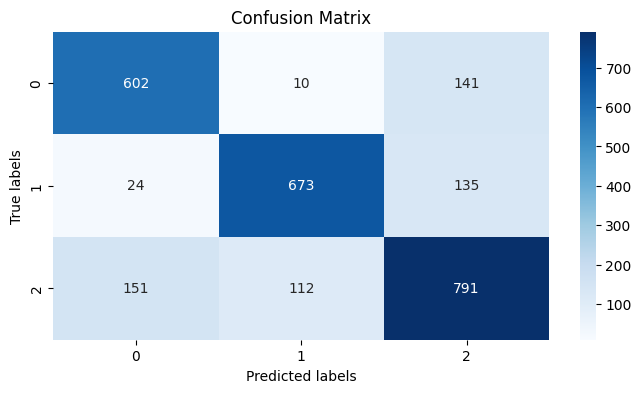

In [49]:
conf_matrix = plot_confusion_matrix(Bertmodel, test_data_loader, config['device'])

<div style="color:white; background:black; text-align: center; font-size: 16px;padding: 1px;">
<h3>BERT + LSTM</h3>
</div>


In [46]:
modelBERTLSTM = BERTLSTMSentiment(
    model_name=config["MODEL_NAME"],
    hidden_dim=config['HIDDEN_DIM'],
    n_layers=config['N_LAYERS'],
    bidirectional=config['BIDIRECTIONAL'],
    dropout=config['DROPOUT'],
    n_classes=config['N_CLASSES']
)

In [47]:

total_params_LSTM, total_gflops_LSTM = models_info(modelBERTLSTM,config['batch_size'] , config['MAX_LEN'], config['device'])

Model Architecture:
BERTLSTMSentiment(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), ep

In [52]:
training_history = trainer(modelBERTLSTM,
                           results_file='bert_lstm_results.txt',
                           model_file='bert_lstm_best_model.pt')

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40
----------------------------------------------------------------------------------------------------
Train loss 0.957681118033149 accuracy 0.5163197998407825
Val loss 0.7836047974499789 accuracy 0.6422070534698521


Epochs:   2%|▎         | 1/40 [00:28<18:16, 28.11s/it]

Epoch 2/40
----------------------------------------------------------------------------------------------------
Train loss 0.77120266540484 accuracy 0.6494370522006141
Val loss 0.7444744489409707 accuracy 0.667235494880546


Epochs:   5%|▌         | 2/40 [00:56<18:00, 28.43s/it]

Epoch 3/40
----------------------------------------------------------------------------------------------------
Train loss 0.7406667979738929 accuracy 0.6691686568861595
Val loss 0.7335313618183136 accuracy 0.6803185437997724


Epochs:   8%|▊         | 3/40 [01:25<17:34, 28.51s/it]

Epoch 4/40
----------------------------------------------------------------------------------------------------
Train loss 0.7280960843237964 accuracy 0.673433412942113
Val loss 0.7266058038581501 accuracy 0.6831626848691694


Epochs:  10%|█         | 4/40 [01:54<17:08, 28.56s/it]

Epoch 5/40
----------------------------------------------------------------------------------------------------
Train loss 0.7194662368297577 accuracy 0.6814511543273059
Val loss 0.7196750532497059 accuracy 0.6865756541524459


Epochs:  12%|█▎        | 5/40 [02:22<16:38, 28.53s/it]

Epoch 6/40
----------------------------------------------------------------------------------------------------
Train loss 0.7127902183749459 accuracy 0.6814511543273059
Val loss 0.7190384897318753 accuracy 0.6871444823663253


Epochs:  15%|█▌        | 6/40 [02:51<16:12, 28.60s/it]

Epoch 7/40
----------------------------------------------------------------------------------------------------
Train loss 0.7038194629820911 accuracy 0.6902081200955306
Val loss 0.7118609840219671 accuracy 0.6922639362912401


Epochs:  18%|█▊        | 7/40 [03:19<15:44, 28.62s/it]

Epoch 8/40
----------------------------------------------------------------------------------------------------
Train loss 0.6950983801213177 accuracy 0.6934493346980553
Val loss 0.7099418347532099 accuracy 0.6962457337883958


Epochs:  20%|██        | 8/40 [03:48<15:13, 28.56s/it]

Epoch 9/40
----------------------------------------------------------------------------------------------------
Train loss 0.6891361270709472 accuracy 0.6973729102695326


Epochs:  22%|██▎       | 9/40 [04:16<14:37, 28.30s/it]

Val loss 0.7098106357184324 accuracy 0.6956769055745164
Epoch 10/40
----------------------------------------------------------------------------------------------------
Train loss 0.6856826425682415 accuracy 0.6976572273399295
Val loss 0.7082833902402358 accuracy 0.6968145620022753


Epochs:  25%|██▌       | 10/40 [04:44<14:14, 28.47s/it]

Epoch 11/40
----------------------------------------------------------------------------------------------------
Train loss 0.6812588932839307 accuracy 0.701751393153645


Epochs:  28%|██▊       | 11/40 [05:12<13:36, 28.16s/it]

Val loss 0.7069722695784135 accuracy 0.6951080773606371
Epoch 12/40
----------------------------------------------------------------------------------------------------
Train loss 0.6719704274697738 accuracy 0.7069259638348686


Epochs:  30%|███       | 12/40 [05:40<13:04, 28.03s/it]

Val loss 0.7093764939091423 accuracy 0.6951080773606371
Epoch 13/40
----------------------------------------------------------------------------------------------------
Train loss 0.6638293791359121 accuracy 0.7099965881951552


Epochs:  32%|███▎      | 13/40 [06:07<12:33, 27.92s/it]

Val loss 0.7114606673067266 accuracy 0.6922639362912401
Epoch 14/40
----------------------------------------------------------------------------------------------------
Train loss 0.6586885469610041 accuracy 0.7118162174456955
Val loss 0.7087384288961237 accuracy 0.7007963594994311


Epochs:  35%|███▌      | 14/40 [06:36<12:10, 28.10s/it]

Epoch 15/40
----------------------------------------------------------------------------------------------------
Train loss 0.6570708248290149 accuracy 0.7106789491641078


Epochs:  38%|███▊      | 15/40 [07:03<11:37, 27.91s/it]

Val loss 0.7070651579986919 accuracy 0.6979522184300341
Epoch 16/40
----------------------------------------------------------------------------------------------------
Train loss 0.6484122813831676 accuracy 0.7186398271352212


Epochs:  40%|████      | 16/40 [07:31<11:08, 27.85s/it]

Val loss 0.7125448178161274 accuracy 0.7007963594994311
Epoch 17/40
----------------------------------------------------------------------------------------------------
Train loss 0.646449495120482 accuracy 0.7182417832366655


Epochs:  42%|████▎     | 17/40 [07:59<10:38, 27.78s/it]

Val loss 0.7074982946569269 accuracy 0.6996587030716723
Epoch 18/40
----------------------------------------------------------------------------------------------------
Train loss 0.6407033561034636 accuracy 0.7281928807005572


Epochs:  45%|████▌     | 18/40 [08:26<10:09, 27.69s/it]

Val loss 0.708937578309666 accuracy 0.6973833902161547
Epoch 19/40
----------------------------------------------------------------------------------------------------
Train loss 0.6367528969049454 accuracy 0.7218241783236665
Val loss 0.7070402974432165 accuracy 0.7042093287827076


Epochs:  48%|████▊     | 19/40 [08:55<09:47, 27.99s/it]

Epoch 20/40
----------------------------------------------------------------------------------------------------
Train loss 0.6324783345786008 accuracy 0.72517911975435


Epochs:  50%|█████     | 20/40 [09:22<09:18, 27.90s/it]

Val loss 0.7099186837673187 accuracy 0.6996587030716723
Epoch 21/40
----------------------------------------------------------------------------------------------------
Train loss 0.6250871061736887 accuracy 0.729955646537018


Epochs:  52%|█████▎    | 21/40 [09:50<08:47, 27.78s/it]

Val loss 0.7149345685135234 accuracy 0.7007963594994311
Epoch 22/40
----------------------------------------------------------------------------------------------------
Train loss 0.6254728278788654 accuracy 0.7279654270442397


Epochs:  55%|█████▌    | 22/40 [10:17<08:18, 27.71s/it]

Val loss 0.7128509174693715 accuracy 0.7025028441410693
Epoch 23/40
----------------------------------------------------------------------------------------------------
Train loss 0.6164658721739595 accuracy 0.7329694074832253
Val loss 0.7126520622860302 accuracy 0.7104664391353811


Epochs:  57%|█████▊    | 23/40 [10:46<07:56, 28.03s/it]

Epoch 24/40
----------------------------------------------------------------------------------------------------
Train loss 0.6153249619765715 accuracy 0.7344478562492892


Epochs:  60%|██████    | 24/40 [11:14<07:25, 27.87s/it]

Val loss 0.713404369354248 accuracy 0.7076222980659841
Epoch 25/40
----------------------------------------------------------------------------------------------------
Train loss 0.6087126375870271 accuracy 0.739053792789719


Epochs:  62%|██████▎   | 25/40 [11:41<06:56, 27.80s/it]

Val loss 0.7249052974310788 accuracy 0.6996587030716723
Epoch 26/40
----------------------------------------------------------------------------------------------------
Train loss 0.6058600628917867 accuracy 0.7433754122597521


Epochs:  65%|██████▌   | 26/40 [12:09<06:28, 27.71s/it]

Val loss 0.7231443150476976 accuracy 0.6979522184300341
Epoch 27/40
----------------------------------------------------------------------------------------------------
Train loss 0.6009732383489609 accuracy 0.7408165586261799


Epochs:  68%|██████▊   | 27/40 [12:37<05:59, 27.69s/it]

Val loss 0.7237877482717687 accuracy 0.7007963594994311
Epoch 28/40
----------------------------------------------------------------------------------------------------
Train loss 0.6038547693057493 accuracy 0.7392812464460367


Epochs:  70%|███████   | 28/40 [13:04<05:31, 27.63s/it]

Val loss 0.7236772867766293 accuracy 0.7013651877133106
Epoch 29/40
----------------------------------------------------------------------------------------------------
Train loss 0.5962162233482707 accuracy 0.744398953713181


Epochs:  72%|███████▎  | 29/40 [13:32<05:04, 27.65s/it]

Val loss 0.7269751483743842 accuracy 0.6979522184300341
Epoch 30/40
----------------------------------------------------------------------------------------------------
Train loss 0.5955133170973171 accuracy 0.7446832707835779


Epochs:  75%|███████▌  | 30/40 [13:59<04:36, 27.62s/it]

Val loss 0.7231729301539335 accuracy 0.699089874857793
Epoch 31/40
----------------------------------------------------------------------------------------------------
Train loss 0.5898820423808965 accuracy 0.7458205390651654


Epochs:  78%|███████▊  | 31/40 [14:27<04:07, 27.53s/it]

Val loss 0.7235524713993072 accuracy 0.6985210466439135
Epoch 32/40
----------------------------------------------------------------------------------------------------
Train loss 0.5855536493388089 accuracy 0.7524166950983737


Epochs:  80%|████████  | 32/40 [14:54<03:40, 27.51s/it]

Val loss 0.7270537734031677 accuracy 0.7002275312855517
Epoch 33/40
----------------------------------------------------------------------------------------------------
Train loss 0.5886201777241447 accuracy 0.7503127487774366


Epochs:  82%|████████▎ | 33/40 [15:21<03:12, 27.44s/it]

Val loss 0.7310906859961424 accuracy 0.699089874857793
Epoch 34/40
----------------------------------------------------------------------------------------------------
Train loss 0.5808166863159699 accuracy 0.7530990560673263


Epochs:  85%|████████▌ | 34/40 [15:49<02:44, 27.43s/it]

Val loss 0.7287110063162717 accuracy 0.7025028441410693
Epoch 35/40
----------------------------------------------------------------------------------------------------
Train loss 0.5798925349929116 accuracy 0.7523598316842943


Epochs:  88%|████████▊ | 35/40 [16:16<02:17, 27.51s/it]

Val loss 0.7301419377326965 accuracy 0.699089874857793
Epoch 36/40
----------------------------------------------------------------------------------------------------
Train loss 0.5806679153713313 accuracy 0.752018651199818


Epochs:  90%|█████████ | 36/40 [16:44<01:50, 27.56s/it]

Val loss 0.7289020370353352 accuracy 0.699089874857793
Epoch 37/40
----------------------------------------------------------------------------------------------------
Train loss 0.5815788446231321 accuracy 0.7523598316842943


Epochs:  92%|█████████▎| 37/40 [17:11<01:22, 27.47s/it]

Val loss 0.7294561808759515 accuracy 0.6979522184300341
Epoch 38/40
----------------------------------------------------------------------------------------------------
Train loss 0.5797884586724368 accuracy 0.7549186853178664


Epochs:  95%|█████████▌| 38/40 [17:39<00:54, 27.48s/it]

Val loss 0.7282850942828438 accuracy 0.6996587030716723
Epoch 39/40
----------------------------------------------------------------------------------------------------
Train loss 0.5728461847522042 accuracy 0.7576481291936767


Epochs:  98%|█████████▊| 39/40 [18:06<00:27, 27.47s/it]

Val loss 0.7297782957553863 accuracy 0.6985210466439135
Epoch 40/40
----------------------------------------------------------------------------------------------------
Train loss 0.5721243478493258 accuracy 0.7530990560673263


Epochs: 100%|██████████| 40/40 [18:34<00:00, 27.86s/it]

Val loss 0.7302855746312575 accuracy 0.6996587030716723
Total training time: 1114.27 seconds


### **BERTLSTM Test**

In [53]:
model_path = '/kaggle/working/bert_lstm_best_model.pt'
modelBERTLSTM.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [54]:
test_acc, _ , average_inference_time = eval_model(
        modelBERTLSTM,
        test_data_loader,
        loss_fn,
        config['device'], 
        )


print(f"Accuracy: {test_acc:.4f}")

Accuracy: 0.6908


In [55]:
print(f"Inference_time: {average_inference_time:.6f} seconds")

Inference_time: 0.012657 seconds


In [56]:
sentence = "XD"
sentiment = predict_sentiment(modelBERTLSTM, sentence)
print(f"The sentiment of the sentence is: {sentiment}")

The sentiment of the sentence is: Neutral


### **Confusion matrix**

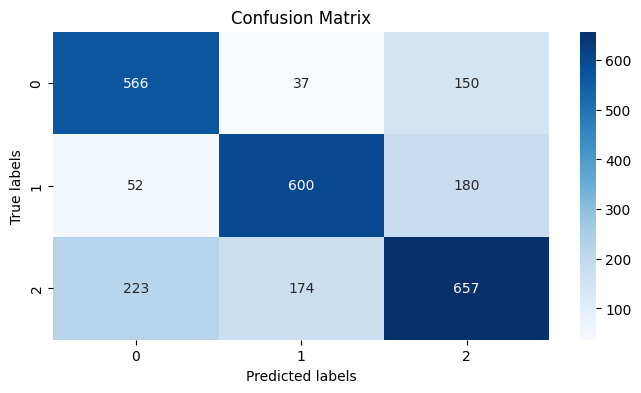

In [57]:
conf_matrix = plot_confusion_matrix(modelBERTLSTM, test_data_loader, config['device'])

<div style="color:white; background:black; text-align: center; font-size: 16px;padding: 1px;">
<h3>BERT + GRU</h3>
</div>


In [58]:
modelBERTGRU = BERTGRUSentiment(
    model_name=config["MODEL_NAME"],
    hidden_dim=config['HIDDEN_DIM'],
    output_dim=config['OUTPUT_DIM'],
    n_layers=config['N_LAYERS'],
    bidirectional=config['BIDIRECTIONAL'],
    dropout=config['DROPOUT'],
    n_classes=config['N_CLASSES']
)
modelBERTGRU = modelBERTGRU.to(config['device'])

In [59]:

total_params_GRU, total_gflops_GRU = models_info(modelBERTGRU,config['batch_size'] , config['MAX_LEN'], config['device'])

Model Architecture:
BERTGRUSentiment(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

In [60]:
training_history = trainer(modelBERTGRU,
                           results_file='bert_gru_results.txt',
                           model_file='bert_gru_best_model.pt')

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40
----------------------------------------------------------------------------------------------------
Train loss 0.9555337388948961 accuracy 0.5332650972364381
Val loss 0.8127792022444985 accuracy 0.629692832764505


Epochs:   2%|▎         | 1/40 [00:27<18:01, 27.72s/it]

Epoch 2/40
----------------------------------------------------------------------------------------------------
Train loss 0.7879768412763423 accuracy 0.6389173205959285
Val loss 0.7609974536028775 accuracy 0.6507394766780432


Epochs:   5%|▌         | 2/40 [00:56<17:46, 28.07s/it]

Epoch 3/40
----------------------------------------------------------------------------------------------------
Train loss 0.7555133321068503 accuracy 0.658819515523712
Val loss 0.7482910264622081 accuracy 0.6700796359499431


Epochs:   8%|▊         | 3/40 [01:24<17:17, 28.04s/it]

Epoch 4/40
----------------------------------------------------------------------------------------------------
Train loss 0.7411801731586456 accuracy 0.6676902081200955
Val loss 0.7381415042010221 accuracy 0.6786120591581342


Epochs:  10%|█         | 4/40 [01:52<16:54, 28.17s/it]

Epoch 5/40
----------------------------------------------------------------------------------------------------
Train loss 0.7311518625237725 accuracy 0.6717275105197316
Val loss 0.7352945441549474 accuracy 0.679749715585893


Epochs:  12%|█▎        | 5/40 [02:20<16:24, 28.13s/it]

Epoch 6/40
----------------------------------------------------------------------------------------------------
Train loss 0.7295905742320148 accuracy 0.6781530763107017
Val loss 0.7301136152310805 accuracy 0.6882821387940842


Epochs:  15%|█▌        | 6/40 [02:48<15:54, 28.09s/it]

Epoch 7/40
----------------------------------------------------------------------------------------------------
Train loss 0.7147032111883164 accuracy 0.6837256908904811
Val loss 0.7273575392636386 accuracy 0.6894197952218429


Epochs:  18%|█▊        | 7/40 [03:16<15:25, 28.04s/it]

Epoch 8/40
----------------------------------------------------------------------------------------------------
Train loss 0.7141401036761024 accuracy 0.6809962470146708
Val loss 0.726367053118619 accuracy 0.6911262798634812


Epochs:  20%|██        | 8/40 [03:44<14:58, 28.09s/it]

Epoch 9/40
----------------------------------------------------------------------------------------------------
Train loss 0.7095262645049528 accuracy 0.6867394518366883
Val loss 0.7210051579908892 accuracy 0.6922639362912401


Epochs:  22%|██▎       | 9/40 [04:13<14:33, 28.19s/it]

Epoch 10/40
----------------------------------------------------------------------------------------------------
Train loss 0.7042957664619792 accuracy 0.6922552030023883


Epochs:  25%|██▌       | 10/40 [04:40<13:56, 27.87s/it]

Val loss 0.720163753899661 accuracy 0.6905574516496018
Epoch 11/40
----------------------------------------------------------------------------------------------------
Train loss 0.6992667229067195 accuracy 0.6922552030023883


Epochs:  28%|██▊       | 11/40 [05:07<13:21, 27.65s/it]

Val loss 0.7177367096597498 accuracy 0.6905574516496018
Epoch 12/40
----------------------------------------------------------------------------------------------------
Train loss 0.6923372965509241 accuracy 0.696406232230183


Epochs:  30%|███       | 12/40 [05:34<12:48, 27.46s/it]

Val loss 0.7186875565485521 accuracy 0.6899886234357224
Epoch 13/40
----------------------------------------------------------------------------------------------------
Train loss 0.691594053290107 accuracy 0.6957807346753099


Epochs:  32%|███▎      | 13/40 [06:01<12:19, 27.39s/it]

Val loss 0.7107830936258489 accuracy 0.6905574516496018
Epoch 14/40
----------------------------------------------------------------------------------------------------
Train loss 0.6826475102793087 accuracy 0.7005003980438985


Epochs:  35%|███▌      | 14/40 [06:28<11:49, 27.31s/it]

Val loss 0.7118860531936992 accuracy 0.6888509670079636
Epoch 15/40
----------------------------------------------------------------------------------------------------
Train loss 0.6825116246396845 accuracy 0.7021494370522006


Epochs:  38%|███▊      | 15/40 [06:55<11:21, 27.25s/it]

Val loss 0.7098842138593847 accuracy 0.6899886234357224
Epoch 16/40
----------------------------------------------------------------------------------------------------
Train loss 0.6808175829865716 accuracy 0.7032867053337882


Epochs:  40%|████      | 16/40 [07:22<10:52, 27.19s/it]

Val loss 0.7099015831947326 accuracy 0.6916951080773606
Epoch 17/40
----------------------------------------------------------------------------------------------------
Train loss 0.6775326344099912 accuracy 0.7052769248265666


Epochs:  42%|████▎     | 17/40 [07:50<10:26, 27.24s/it]

Val loss 0.7087480523369529 accuracy 0.6899886234357224
Epoch 18/40
----------------------------------------------------------------------------------------------------
Train loss 0.6758713966608048 accuracy 0.7047082906857728


Epochs:  45%|████▌     | 18/40 [08:17<09:58, 27.19s/it]

Val loss 0.7062058513814753 accuracy 0.6894197952218429
Epoch 19/40
----------------------------------------------------------------------------------------------------
Train loss 0.6730158305710012 accuracy 0.7051063345843285


Epochs:  48%|████▊     | 19/40 [08:44<09:31, 27.21s/it]

Val loss 0.7094138882376931 accuracy 0.6916951080773606
Epoch 20/40
----------------------------------------------------------------------------------------------------
Train loss 0.6659945279359818 accuracy 0.7096554077106789


Epochs:  50%|█████     | 20/40 [09:11<09:04, 27.21s/it]

Val loss 0.7070673617449674 accuracy 0.6922639362912401
Epoch 21/40
----------------------------------------------------------------------------------------------------
Train loss 0.6667587156729264 accuracy 0.7079495052882975


Epochs:  52%|█████▎    | 21/40 [09:38<08:35, 27.13s/it]

Val loss 0.7071032101457769 accuracy 0.6905574516496018
Epoch 22/40
----------------------------------------------------------------------------------------------------
Train loss 0.6662161325866526 accuracy 0.7109632662345047


Epochs:  55%|█████▌    | 22/40 [10:05<08:09, 27.18s/it]

Val loss 0.7062597881663929 accuracy 0.6916951080773606
Epoch 23/40
----------------------------------------------------------------------------------------------------
Train loss 0.6575317524779927 accuracy 0.712953485727283
Val loss 0.706233041936701 accuracy 0.6934015927189988


Epochs:  57%|█████▊    | 23/40 [10:33<07:46, 27.42s/it]

Epoch 24/40
----------------------------------------------------------------------------------------------------
Train loss 0.6622683558680794 accuracy 0.7131809393836006


Epochs:  60%|██████    | 24/40 [11:01<07:17, 27.37s/it]

Val loss 0.7060214373198422 accuracy 0.6916951080773606
Epoch 25/40
----------------------------------------------------------------------------------------------------
Train loss 0.6553536774895408 accuracy 0.7157397930171727
Val loss 0.7070773233066906 accuracy 0.6962457337883958


Epochs:  62%|██████▎   | 25/40 [11:29<06:53, 27.58s/it]

Epoch 26/40
----------------------------------------------------------------------------------------------------
Train loss 0.6541695556857369 accuracy 0.715626066189014


Epochs:  65%|██████▌   | 26/40 [11:56<06:24, 27.49s/it]

Val loss 0.7054893406954679 accuracy 0.6956769055745164
Epoch 27/40
----------------------------------------------------------------------------------------------------
Train loss 0.6559515172243118 accuracy 0.7169907881269192


Epochs:  68%|██████▊   | 27/40 [12:23<05:55, 27.33s/it]

Val loss 0.7054702991789038 accuracy 0.6939704209328782
Epoch 28/40
----------------------------------------------------------------------------------------------------
Train loss 0.6530577554486015 accuracy 0.717730012509951


Epochs:  70%|███████   | 28/40 [12:50<05:27, 27.27s/it]

Val loss 0.7059612317518754 accuracy 0.6922639362912401
Epoch 29/40
----------------------------------------------------------------------------------------------------
Train loss 0.6465469359809702 accuracy 0.7179574661662687


Epochs:  72%|███████▎  | 29/40 [13:17<04:59, 27.20s/it]

Val loss 0.70719418796626 accuracy 0.6956769055745164
Epoch 30/40
----------------------------------------------------------------------------------------------------
Train loss 0.6501595423980193 accuracy 0.7196633685886501


Epochs:  75%|███████▌  | 30/40 [13:44<04:31, 27.18s/it]

Val loss 0.7056764288382097 accuracy 0.6928327645051194
Epoch 31/40
----------------------------------------------------------------------------------------------------
Train loss 0.6449974476749247 accuracy 0.7192653246900944


Epochs:  78%|███████▊  | 31/40 [14:11<04:03, 27.10s/it]

Val loss 0.7070282735607841 accuracy 0.6945392491467577
Epoch 32/40
----------------------------------------------------------------------------------------------------
Train loss 0.6426741387627342 accuracy 0.721596724667349


Epochs:  80%|████████  | 32/40 [14:38<03:37, 27.13s/it]

Val loss 0.7068763787096197 accuracy 0.6945392491467577
Epoch 33/40
----------------------------------------------------------------------------------------------------
Train loss 0.6407370238954371 accuracy 0.7237006709882862


Epochs:  82%|████████▎ | 33/40 [15:06<03:09, 27.12s/it]

Val loss 0.7058058419010856 accuracy 0.6962457337883958
Epoch 34/40
----------------------------------------------------------------------------------------------------
Train loss 0.643414729996161 accuracy 0.7194359149323325
Val loss 0.7054401191798123 accuracy 0.6968145620022753


Epochs:  85%|████████▌ | 34/40 [15:33<02:44, 27.34s/it]

Epoch 35/40
----------------------------------------------------------------------------------------------------
Train loss 0.6428876603191549 accuracy 0.7214829978391902
Val loss 0.7034235407005657 accuracy 0.6979522184300341


Epochs:  88%|████████▊ | 35/40 [16:02<02:18, 27.61s/it]

Epoch 36/40
----------------------------------------------------------------------------------------------------
Train loss 0.6408571937409314 accuracy 0.7233594905038099


Epochs:  90%|█████████ | 36/40 [16:29<01:49, 27.41s/it]

Val loss 0.7032231737266887 accuracy 0.6973833902161547
Epoch 37/40
----------------------------------------------------------------------------------------------------
Train loss 0.6358940315788443 accuracy 0.7258614807233026


Epochs:  92%|█████████▎| 37/40 [16:56<01:22, 27.35s/it]

Val loss 0.7043663973158056 accuracy 0.6951080773606371
Epoch 38/40
----------------------------------------------------------------------------------------------------
Train loss 0.6344733638113196 accuracy 0.7247810758557944


Epochs:  95%|█████████▌| 38/40 [17:23<00:54, 27.29s/it]

Val loss 0.705284863168543 accuracy 0.6962457337883958
Epoch 39/40
----------------------------------------------------------------------------------------------------
Train loss 0.6391335619037801 accuracy 0.7256340270669851


Epochs:  98%|█████████▊| 39/40 [17:50<00:27, 27.20s/it]

Val loss 0.7051347266543996 accuracy 0.6956769055745164
Epoch 40/40
----------------------------------------------------------------------------------------------------
Train loss 0.6373805984583768 accuracy 0.7248379392698737


Epochs: 100%|██████████| 40/40 [18:17<00:00, 27.45s/it]

Val loss 0.704326684366573 accuracy 0.6968145620022753
Total training time: 1097.84 seconds


### **BERTGRU Test**

In [61]:
model_path = '/kaggle/working/bert_gru_best_model.pt'
modelBERTGRU.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [62]:
test_acc, _ , average_inference_time = eval_model(
        modelBERTGRU,
        test_data_loader,
        loss_fn,
        config['device'], 
        )
print(f"Accuracy: {test_acc:.4f}")

Accuracy: 0.6991


In [63]:
print(f"Inference_time: {average_inference_time:.6f} seconds")

Inference_time: 0.013407 seconds


### **Confusion matrix**

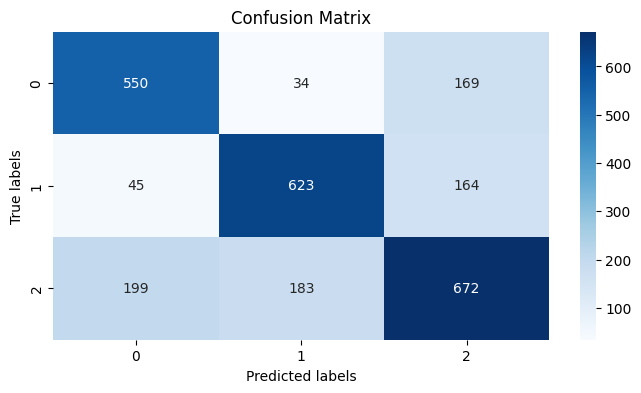

In [65]:
conf_matrix = plot_confusion_matrix(modelBERTGRU, test_data_loader, config['device'])